# Polarizability Regression

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import HuberRegressor, LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

### Data Processing

Load & Proccess Data

In [2]:
master = pd.read_csv('polarizability_master.csv')
master.tail()

,ID,gfn2_polar(A^3),polar(A^3)
70,867_397_111011,259.184933,432.635864
71,379_282_000100,260.776229,464.997122
72,379_525_001000,276.044063,415.776671
73,364_1073_110000,152.236000,520.698000
74,1073_690_001111,170.534000,743.582000


### Method Definition

In [3]:
'''
    Calculates root mean square error

    Parameters
    ---------
    predictions: ndarray of floats
        expected values [based on best fit line]
    observations: ndarray of floats
        observed values
    
    Returns
    -------
    rmse: float
        root mean square error
'''
def calc_rmse(predictions, observations):
    rmse = np.sqrt(((predictions - observations) ** 2).mean())
    return rmse

In [4]:
'''
    Performs Huber linear regression on data set and calculates associated values [ROBUST TO OUTLIERS]

    Parameters
    ---------
    x: ndarray of floats
        x values
    y: ndarray of floats
        y values
    intercept: boolean
        if true, calculates y intercept, if false sets y intercept to 0 (forces fit)
    
    Returns
    -------
    lin_regress_var: list of floats
        slope, y-intercept, r^2, root mean square error
'''
def perform_huber_regress(x, y, intercept=True):
    
    # 2D X array necessary for sklearn
    xi = x.reshape((-1,1))
    
    model = HuberRegressor(fit_intercept=intercept)
    model.fit(xi, y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(xi, y)
    
    # calculate RMSE
    y_pred = y
    y_true = []
    for val in x: 
        y_tr = slope*val + intercept
        y_true.append(y_tr)
    y_true = np.array(y_true)

    rmse = calc_rmse(y_pred, y_true)
    
    huber_regress_var = [slope, intercept, r_squared, rmse]
    
    return huber_regress_var

In [5]:
# matplotlib global formatting

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rcParams['figure.dpi'] = 300

### Calculate MAE

In [6]:
x = master['gfn2_polar(A^3)'].values
y = master['polar(A^3)'].values

# perform Huber regression
slope, intercept, r_squared, rmserror = perform_huber_regress(x, y, False)

master_copy = master.copy()
master_copy['huber'] = master_copy['gfn2_polar(A^3)']*slope
master_copy.tail()

,ID,gfn2_polar(A^3),polar(A^3),huber
70,867_397_111011,259.184933,432.635864,431.882380
71,379_282_000100,260.776229,464.997122,434.533973
72,379_525_001000,276.044063,415.776671,459.974912
73,364_1073_110000,152.236000,520.698000,253.672331
74,1073_690_001111,170.534000,743.582000,284.162466


In [7]:
# MAE wb97X(D) vs linear-fit GFN2
mae=mean_absolute_error(master_copy['polar(A^3)'], master_copy['huber'])
mae

100.45038071037195

### Plot

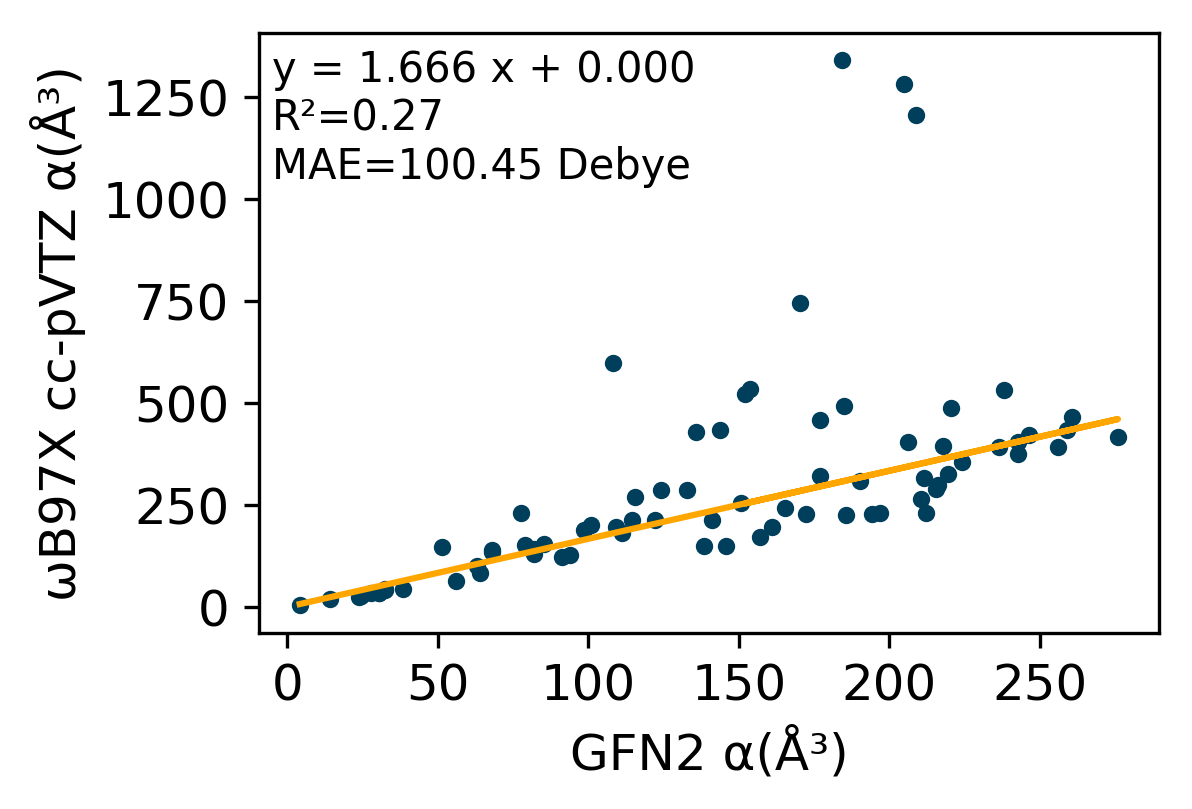

In [8]:
# set up subplot figure
top = 0.5
bottom = 0
left = 0
right = 0.5
plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, wspace=0.25)

x = master['gfn2_polar(A^3)'].values
y = master['polar(A^3)'].values

# label axes
plt.xlabel('GFN2 α(Å³)')
plt.ylabel('ωB97X cc-pVTZ α(Å³)')

# perform linear regression
slope, intercept, r_squared, rmserror = perform_huber_regress(x, y, False)

# plot points & regression lines
plt.scatter(x, y, s=10, c='#003f5c')
plt.plot(x, slope*x+intercept, c='#ffa600')

# print regression line equation & r-squared
if intercept < 0:
    y_int = '- %.3f' % abs(intercept)
else: 
    y_int = '+ %.3f' % intercept
plt.text(-5, 1050, 'y = %.3f x %s\nR²=%.2f\nMAE=%.2f Debye' % (slope, y_int, r_squared, mae))


plt.savefig('polar_regression.png', transparent=False, bbox_inches='tight')

plt.show()